In [1]:
import pandas as pd

# read the data from 80*80 pixel
data = pd.read_table('./all_geo.txt',header=None,sep=' ',index_col=False) # last column is NaN
data = data.iloc[:,0:data.shape[1]-1] # take the last col. away

# read the thoughness
label = pd.read_table('./toughness.txt',header=None,sep=' ',index_col=False) 
label.rename(columns={0:"Toughness"},inplace=True) # change the col. name from 0 to "Toughness"

# combine the label if it needs to be shuffled, but not be used now
# data_combine = pd.concat([data,label],axis=1) # combine the data and label

In [2]:
import numpy as np

# reshape the data into 80*80 for CNN input
data_reshape = np.array(data).reshape((10000, 80, 80, 1)) 

In [3]:
from sklearn.model_selection import train_test_split

# 20% for validation
X_train, X_val, y_train, y_val = train_test_split(data_reshape, label, test_size=0.2, random_state=42)

In [4]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models

# setting the hyper-parameters
learning_rate_set = 0.001
batch_size_set = 10
epochs_set = 10
 
# learning rate decay to decrease the loss
def learning_rate_scheduler(epoch, lr): 
    if (epoch+1) > 5:
        lr = 0.8*lr
    return lr    
        
# LeNet-5, originally input (32,32,1) and output 10 (softmax)
model= models.Sequential()
model.add(layers.Conv2D(filters=6,kernel_size=(5,5),input_shape=(80,80,1),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2, 2)))
model.add(layers.Conv2D(filters=16, kernel_size=(5,5),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(120,activation='relu'))
model.add(layers.Dense(84,activation='relu'))

# for regression, change the final step from softmax to linear
model.add(layers.Dense(1, activation='linear')) # only 1 output(float), y = a(wx + b), a = 1

model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate_set),
              loss = 'mean_squared_error', metrics = ['mse'])

In [5]:
# start to train
history = model.fit(x = X_train, y = y_train, validation_data = 
                    (X_val, y_val),epochs = epochs_set, batch_size = batch_size_set,
                   callbacks=[tf.keras.callbacks.LearningRateScheduler(learning_rate_scheduler, verbose=1)])
# save the model
# model.save("final_project.h5") 


Epoch 00001: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 1/10
800/800 [==============================] - 2s 3ms/step - loss: 1.0360 - mse: 1.0360 - val_loss: 0.3840 - val_mse: 0.3840

Epoch 00002: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 2/10
800/800 [==============================] - 2s 3ms/step - loss: 0.2826 - mse: 0.2826 - val_loss: 0.1929 - val_mse: 0.1929

Epoch 00003: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 3/10
800/800 [==============================] - 2s 3ms/step - loss: 0.1577 - mse: 0.1577 - val_loss: 0.1361 - val_mse: 0.1361

Epoch 00004: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 4/10
800/800 [==============================] - 2s 3ms/step - loss: 0.1151 - mse: 0.1151 - val_loss: 0.1241 - val_mse: 0.1241

Epoch 00005: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 5/10
800/800 [===========================

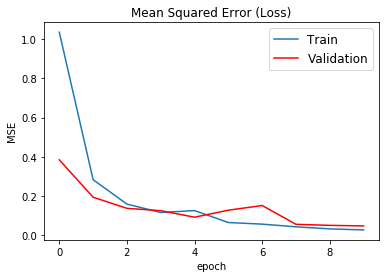

In [6]:
import matplotlib.pyplot as plt

# plot the result
plt.figure(0)
plt.title("Mean Squared Error (Loss)")
plt.plot(history.history['mse'],label='Train')
plt.plot(history.history['val_mse'],'r', label='Validation')
plt.legend(loc="upper right",fontsize='large')
plt.xlabel('epoch')
plt.ylabel('MSE')
plt.show()

In [7]:
# predict from the same 10000 data
toughness_pred = model.predict(data_reshape)

y_pred_pd = pd.DataFrame(data=toughness_pred, columns=['ML']) # array to dataframe

# combine the data, toughness, and predicted toughness, and save the file
data_combine = pd.concat([data,label,y_pred_pd],axis=1) 
data_combine = data_combine.reset_index()
data_combine.to_csv('group_5.csv',index=False) # use it when save the file

In [8]:
from sklearn.metrics import mean_squared_error

# calculate the MSE from predicted value
print('MSE : ',mean_squared_error(label,y_pred_pd)) # calculate MSE

MSE :  0.027893576698777053
